<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/03_TextImage/captum_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Captum Interpretability Library Example using Titanic Data

Deep Neural Networks are often criticised for being "black boxes." 

To address this criticism, the community has focused on research and tools to improve the explainability of the hidden layers of deep neural networks.

This example illustrates how one such tool can be used. The tool is Captum, and is developed by the same team as PyTorch, another popular deep learning framework.

- Note that the tool is cutting edge, and therefore only works with PyTorch (not Keras). But don't worry, the neural network is quite simple to implement in PyTorch.
- We will be adapting the following tutorial which performs a classification prediction using the Titanic Dataset.  
- We will also be running this on Google Colaboratory so that we don't have to install too many libraries. If you would like to run this locally, you will need to manually install PyTorch.

Reference: https://www.captum.ai/tutorials/Titanic_Basic_Interpret

In [2]:
!pip3 install captum

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
    100% |████████████████████████████████| 532kB 474kB/s ta 0:00:01    78% |█████████████████████████▎      | 419kB 4.2MB/s eta 0:00:01


In [3]:
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
# convert categorical features to on-hot

df = pd.concat([df,
                pd.get_dummies(df['sex']),
                pd.get_dummies(df['embarked'], prefix='embark'),
                pd.get_dummies(df['pclass'], prefix='class')],
              axis=1)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,body,home.dest,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,...,NaN,"St Louis, MO",1,0,0,0,1,1,0,0
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,...,135.0,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0


In [6]:
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,body,home.dest,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,...,NaN,"St Louis, MO",1,0,0,0,1,1,0,0
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,...,135.0,"Montreal, PQ / Chesterville, ON",0,1,0,0,1,1,0,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,...,NaN,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0


In [7]:
df.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest',
         'sex', 'embarked', 'pclass'],
        axis=1, inplace=True)
df.head()

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.00,0,0,211.3375,1,0,0,0,1,1,0,0
1,1,0.92,1,2,151.5500,0,1,0,0,1,1,0,0
2,0,2.00,1,2,151.5500,1,0,0,0,1,1,0,0
3,0,30.00,1,2,151.5500,0,1,0,0,1,1,0,0
4,0,25.00,1,2,151.5500,1,0,0,0,1,1,0,0


In [8]:
np.random.seed(42)
torch.manual_seed(42)

In [9]:
target = 'survived'
y = df.loc[:, target].values
X = df.loc[:, df.columns != target].values
feature_names = df.columns[df.columns != target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42)

In [11]:
class TitanicSimpleNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(12, 12)
    self.act1 = nn.Sigmoid()
    self.linear2 = nn.Linear(12, 8)
    self.act2 = nn.Sigmoid()
    self.linear3 = nn.Linear(8, 2)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)
    return self.softmax(x)

In [12]:
criterion = nn.CrossEntropyLoss()
num_epochs = 200

net = TitanicSimpleNNModel()
optimizer = optim.Adam(net.parameters(), lr=.1)
input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
label_tensor = torch.from_numpy(y_train)

for epoch in range(num_epochs):
  output = net(input_tensor)
  loss = criterion(output, label_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if epoch % 20 == 0:
    print(f'Epoch {epoch+1}/{num_epochs} => Loss: {loss.item():.2f}')

Epoch 1/200 => Loss: 0.71
Epoch 21/200 => Loss: 0.58
Epoch 41/200 => Loss: 0.51
Epoch 61/200 => Loss: 0.50
Epoch 81/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.49
Epoch 141/200 => Loss: 0.49
Epoch 161/200 => Loss: 0.49
Epoch 181/200 => Loss: 0.49


In [13]:
pred_probs = net(input_tensor).detach().numpy()
preds = pred_probs.argmax(axis=1)
print(f'Train Accuracy: {accuracy_score(y_train, preds)}')

Train Accuracy: 0.8253275109170306


In [14]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
pred_probs = net(test_input_tensor).detach().numpy()
preds = pred_probs.argmax(axis=1)
print(f'Test Accuracy: {accuracy_score(y_test, preds)}')

Test Accuracy: 0.7888040712468194


### Integrated Gradients

A Feature Attribution technique. Takes tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the given examples.

https://arxiv.org/pdf/1703.01365.pdf

In [15]:
ig = IntegratedGradients(net)

In [16]:
test_input_tensor.requires_grad_() # require gradient

# get input attributions for target = 1 (survival) using Integrated Gradients
# this approximates the integral of gradients along the path from a baseline
# input to the given input.
attr, delta = ig.attribute(test_input_tensor, target=1,
                           return_convergence_delta=True)
attr = attr.detach().numpy()

In [17]:
attr

array([[ 0.02784212, -0.        ,  0.        , ...,  0.        ,
         0.        , -0.02634219],
       [ 0.05248475, -0.0582265 ,  0.06094419, ...,  0.        ,
         0.        , -0.21440436],
       [ 0.02260645, -0.        ,  0.        , ...,  0.        ,
         0.        , -0.02507954],
       ...,
       [-0.39178833, -0.        ,  0.        , ...,  0.        ,
         1.3407902 , -0.        ],
       [-1.2481393 , -0.        ,  0.        , ...,  0.        ,
         0.        , -2.4793487 ],
       [ 0.06881139, -0.02830721,  0.        , ...,  0.        ,
         0.10791326, -0.        ]], dtype=float32)

In [18]:
# attributions for each row, get their mean
attr.mean(axis=0)

array([-0.22862697, -0.06802853,  0.02468084,  0.43662053,  0.36320662,
       -0.5254875 ,  0.05596821,  0.01766445, -0.01421282,  0.23671284,
        0.23694618, -0.25034913], dtype=float32)

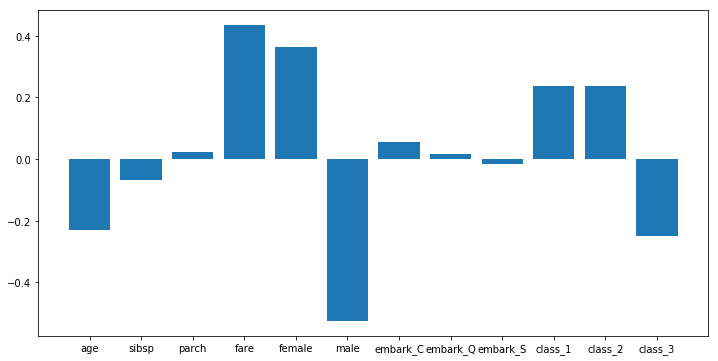

In [19]:
x_pos = (np.arange(len(feature_names)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x_pos, attr.mean(axis=0))
ax.set_xticks(x_pos)
ax.set_xticklabels(list(feature_names))
plt.show()

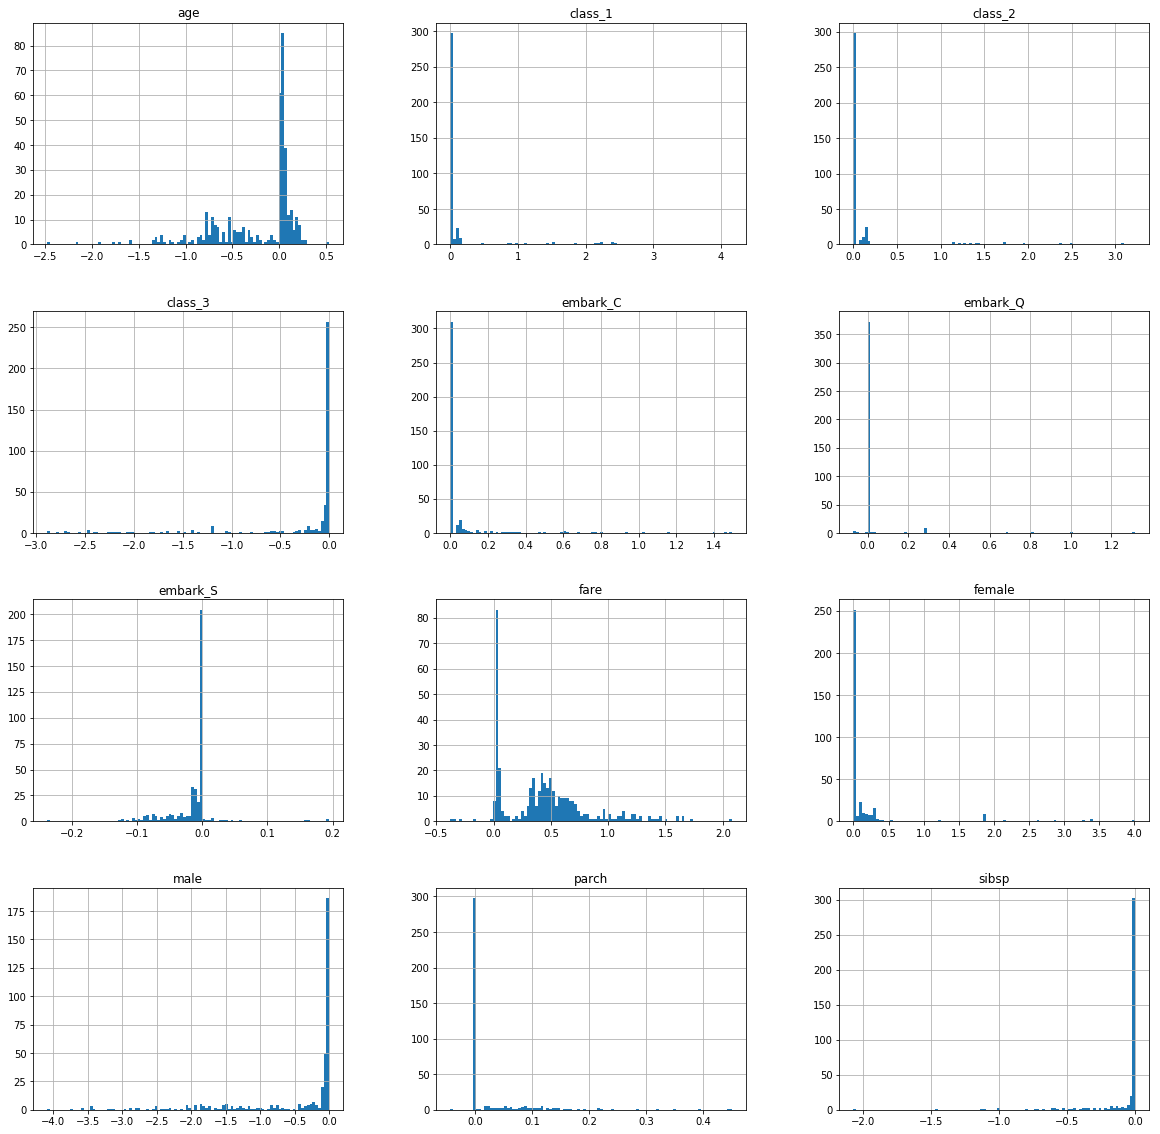

In [20]:
# visualise distributions of the attributes
# because these are generated from test set, so the attribution may not reflect
# actual dataset distribution
attr_df = pd.DataFrame(attr, columns=feature_names)
attr_df.hist(figsize=(20, 20), bins=100)
plt.show()

In [21]:
# bucket examples by value and plot average attribution.
# size of dot is proportion to number of samples of a given value bucket.

def plot_binned_attribution(values, attrs, name, ax):
  bin_means, bin_edges, _ = stats.binned_statistic(values, 
                                                   attrs,
                                                   statistic='mean',
                                                   bins=6)
  bin_count, _, _ = stats.binned_statistic(values,
                                           attrs,
                                           statistic='count',
                                           bins=6)

  bin_width = (bin_edges[1] - bin_edges[0])
  bin_centers = bin_edges[1:] - bin_width/2
  ax.scatter(bin_centers, bin_means, s=bin_count)
  ax.set_title(name)

/usr/lib/python3/dist-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


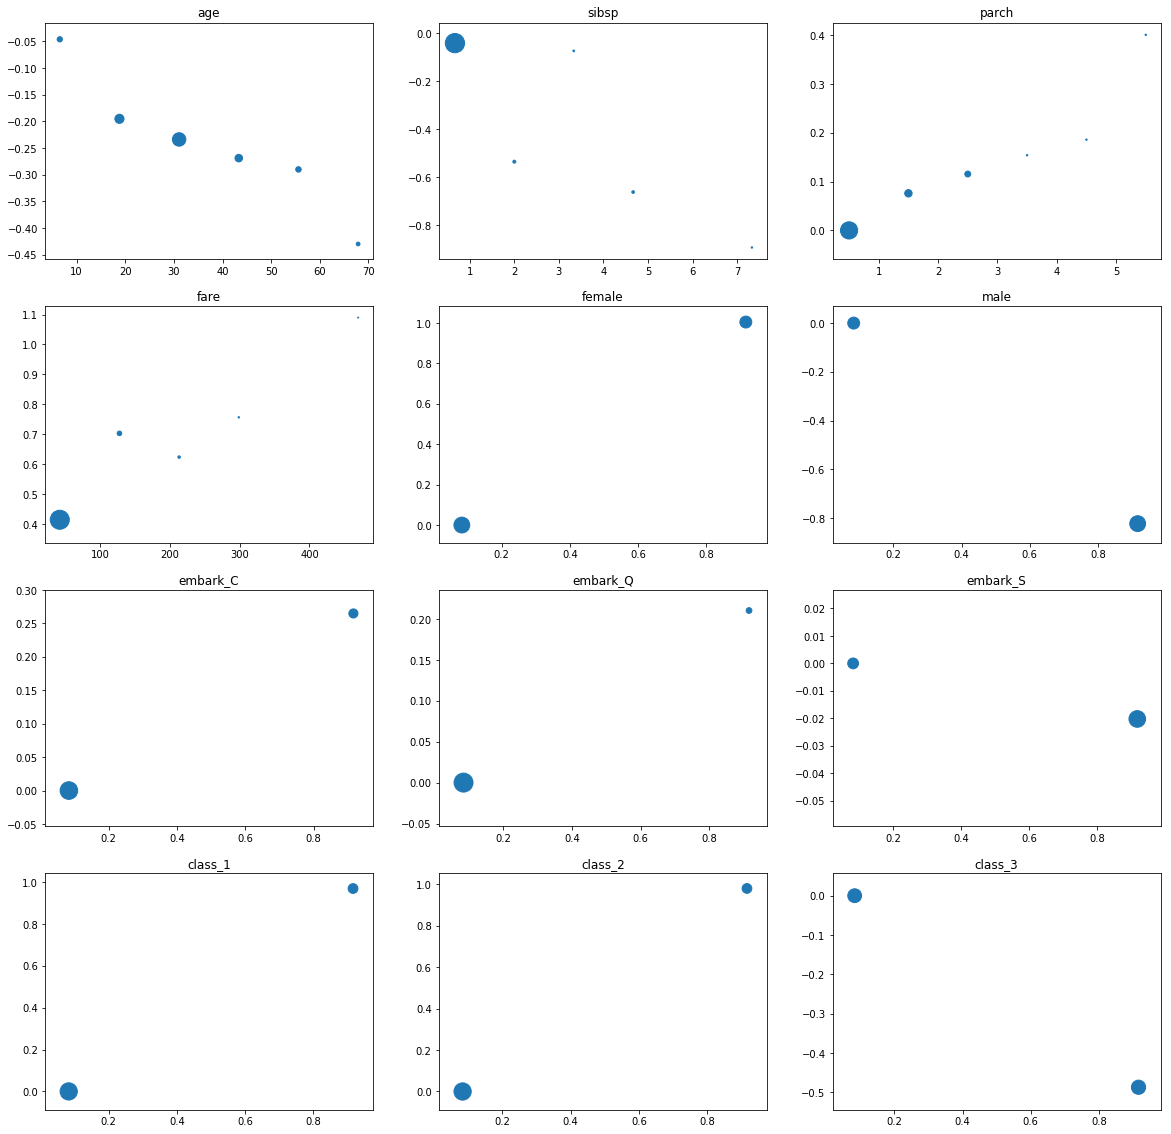

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i in range(len(feature_names)):
  plot_binned_attribution(X_test[:, i], attr[:, i], feature_names[i], axes[i])
plt.show()

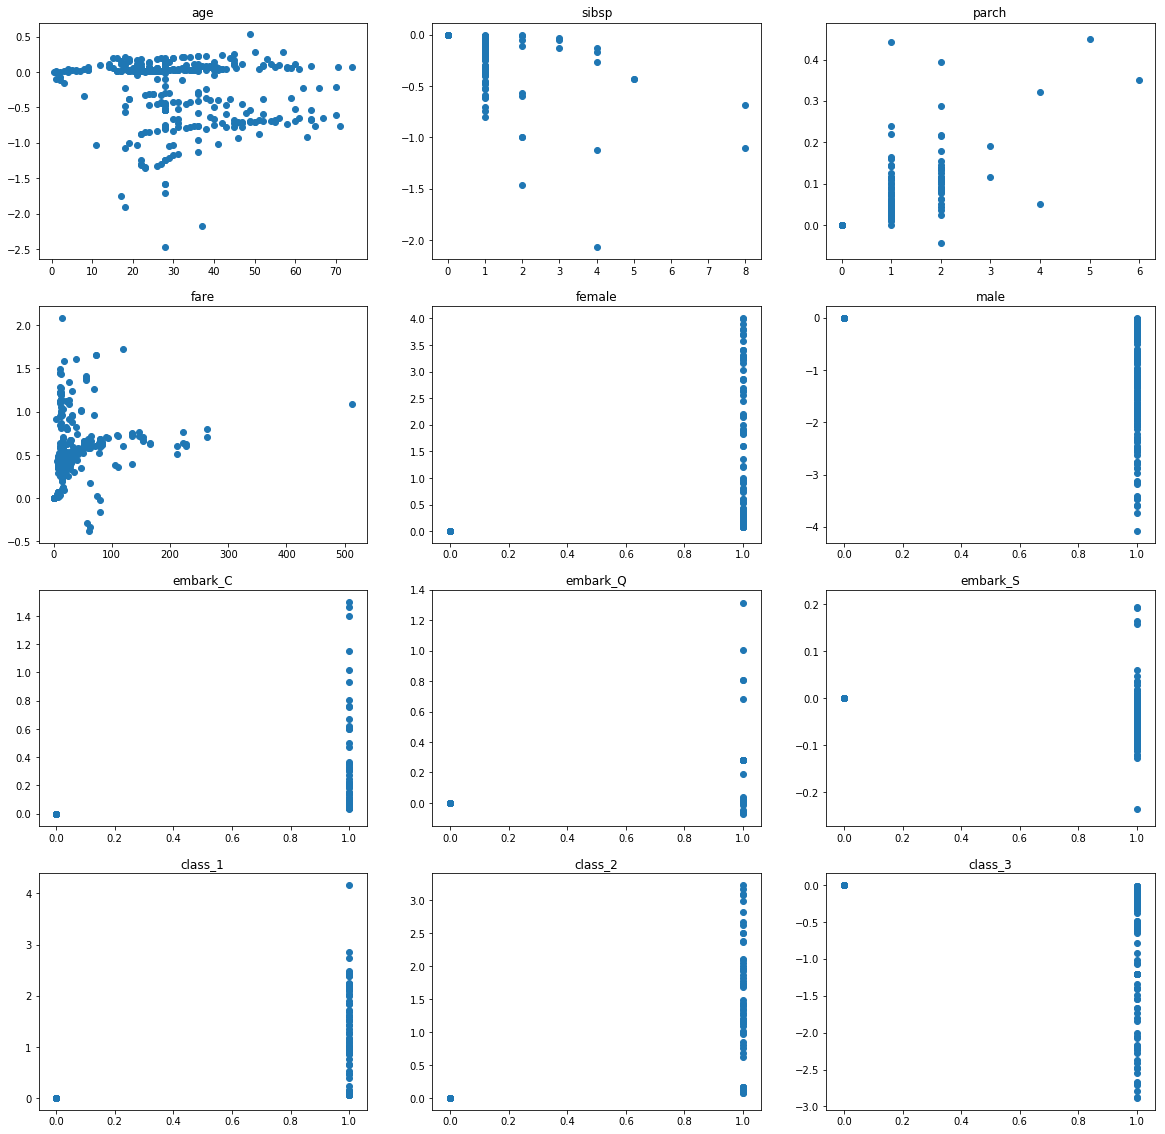

In [23]:
# scatter plot of values and attr

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i in range(len(feature_names)):
  axes[i].scatter(X_test[:, i], attr[:, i])
  axes[i].set_title(feature_names[i])
plt.show()

### Layer Attributions

Understand the importance (conductance) of the neurons in a particular neural network layer.

https://arxiv.org/abs/1805.12233

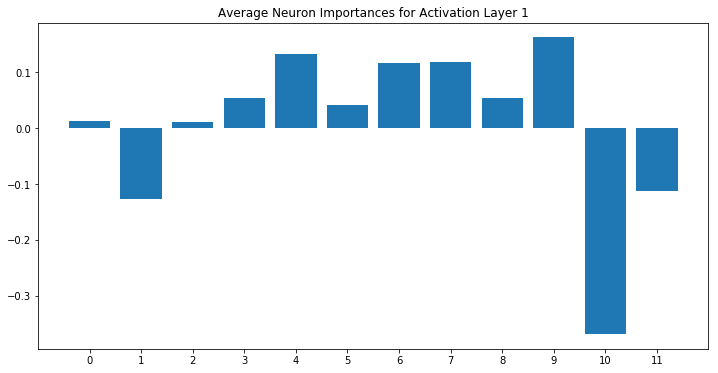

In [24]:
lc_act1 = LayerConductance(net, net.act1)
lc_vals = lc_act1.attribute(test_input_tensor, target=1)
lc_vals = lc_vals.detach().numpy()

fig, ax = plt.subplots(figsize=(12, 6))

neuron_indices = range(12)
ax.bar(neuron_indices, lc_vals.mean(axis=0))
ax.set_xticks(neuron_indices)
ax.set_title('Average Neuron Importances for Activation Layer 1')
plt.show()

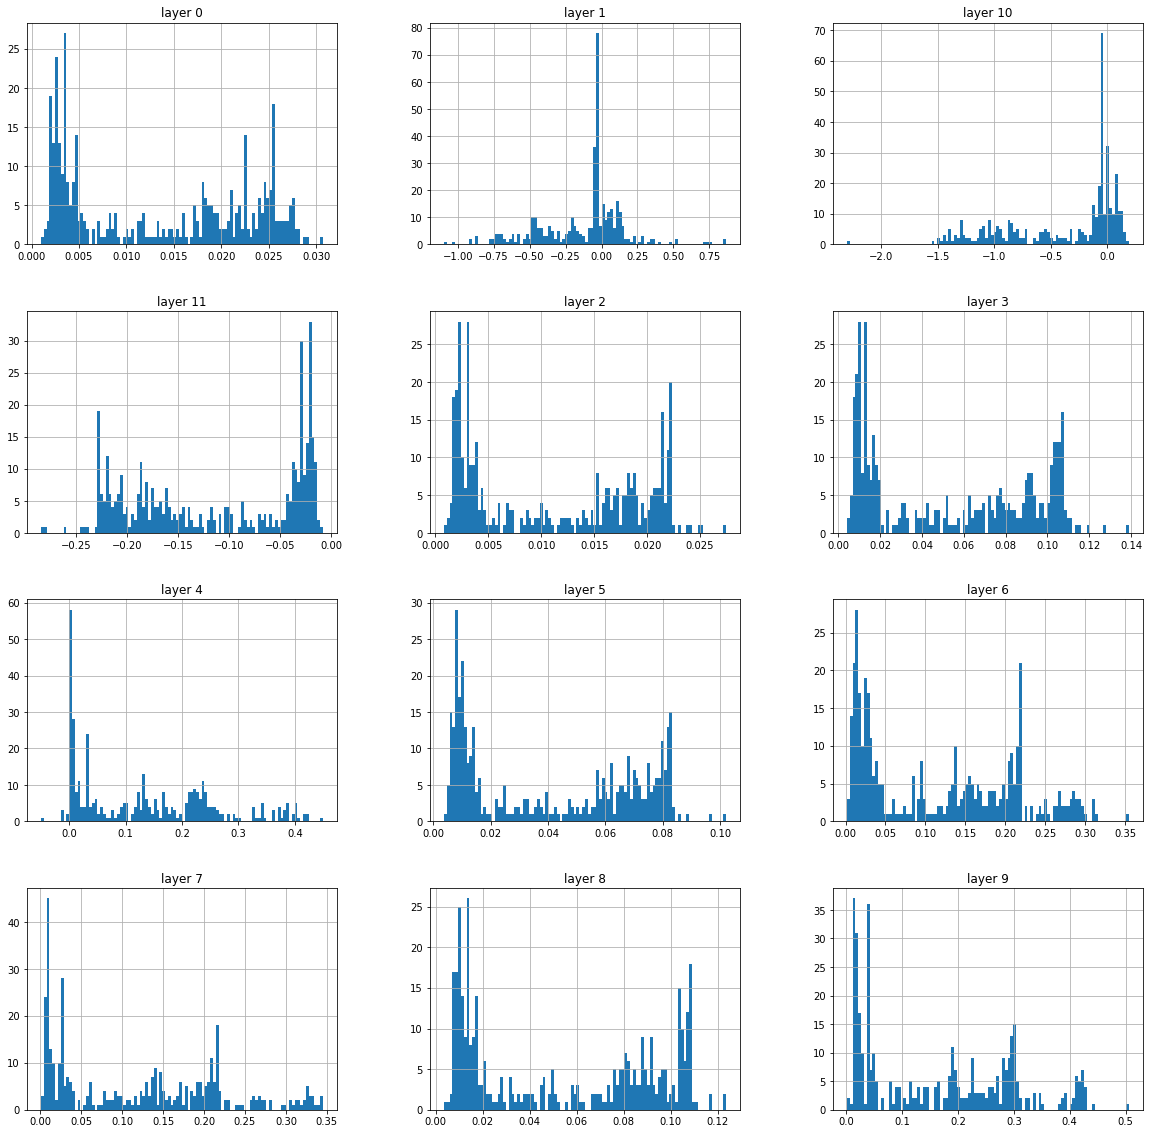

In [25]:
# visualise distributions of the neuron importances
colnames = [f'layer {i}' for i in range(lc_vals.shape[1])]
lc_vals_df = pd.DataFrame(lc_vals, columns=colnames)
lc_vals_df.hist(figsize=(20, 20), bins=100)
plt.show()

In [26]:
# stats
lc_vals_df.describe()

,layer 0,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,0.013269,-0.126319,0.011190,0.053602,0.133020,0.041508,0.115745,0.118036,0.053800,0.162321,-0.368555,-0.112014
std,0.009422,0.291036,0.007987,0.039089,0.122587,0.029636,0.093984,0.100629,0.039022,0.132683,0.494790,0.081290
min,0.000991,-1.094784,0.000827,0.004183,-0.050151,0.003732,0.001921,0.001060,0.003566,0.001834,-2.303570,-0.284725
25%,0.003548,-0.299333,0.003015,0.012906,0.013990,0.010531,0.024980,0.022491,0.013993,0.034795,-0.816867,-0.187791
50%,0.012619,-0.035177,0.010460,0.051650,0.123353,0.039282,0.100487,0.109420,0.049175,0.145615,-0.075652,-0.103746
75%,0.022492,0.024906,0.018868,0.092361,0.225211,0.070311,0.203136,0.201813,0.091945,0.282850,0.000146,-0.028537
max,0.030721,0.864434,0.027430,0.138919,0.449735,0.102065,0.354291,0.345035,0.123500,0.505874,0.193217,-0.008208


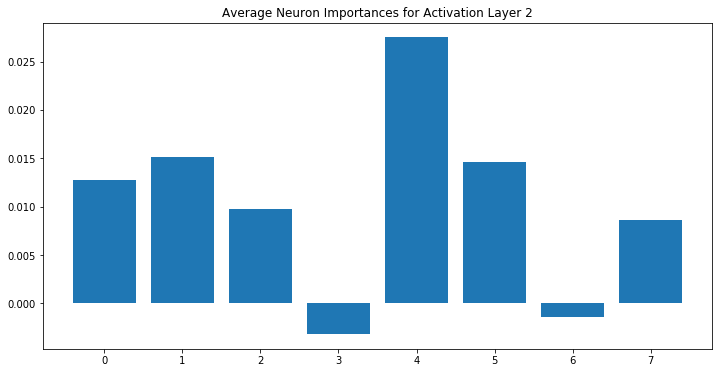

In [27]:
# let's see layer 2
lc_act2 = LayerConductance(net, net.act2)
lc_vals = lc_act2.attribute(test_input_tensor, target=1)
lc_vals = lc_vals.detach().numpy()

fig, ax = plt.subplots(figsize=(12, 6))
neuron_indices = range(8)
ax.bar(neuron_indices, lc_vals.mean(axis=0))
ax.set_xticks(neuron_indices)
ax.set_title('Average Neuron Importances for Activation Layer 2')
plt.show()

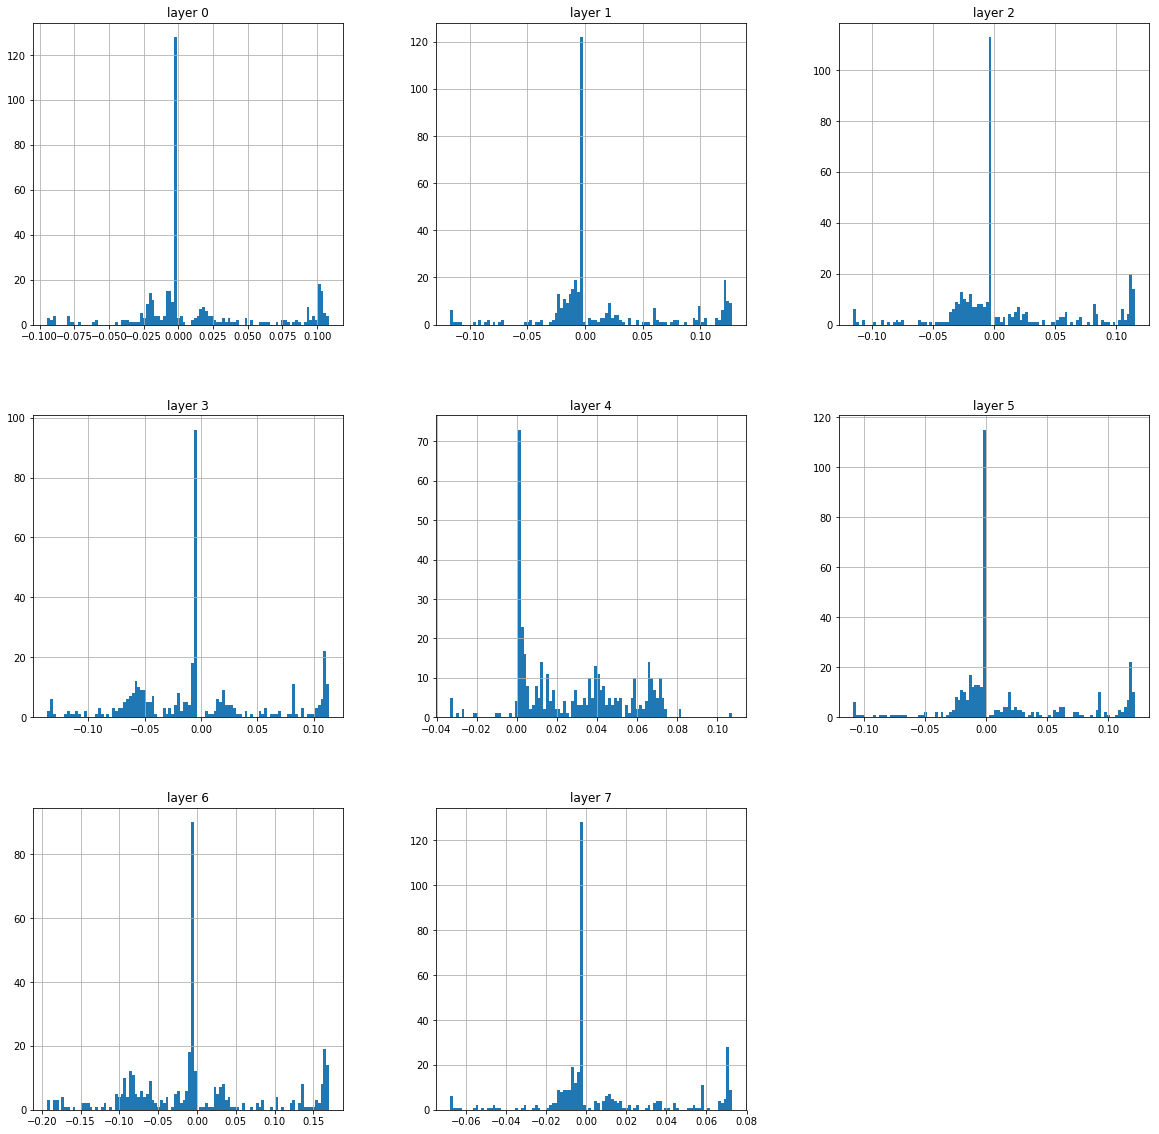

In [28]:
# visualise distributions of the neuron importances
colnames = [f'layer {i}' for i in range(lc_vals.shape[1])]
lc_vals_df = pd.DataFrame(lc_vals, columns=colnames)
lc_vals_df.hist(figsize=(20, 20), bins=100)
plt.show()

In [29]:
# stats
lc_vals_df.describe()

,layer 0,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,0.012746,0.015182,0.009780,-0.003154,0.027489,0.014646,-0.001366,0.008640
std,0.045922,0.054404,0.051726,0.060419,0.026858,0.051775,0.088874,0.031482
min,-0.094419,-0.116926,-0.115154,-0.136479,-0.033143,-0.108618,-0.192988,-0.067695
25%,-0.007262,-0.010106,-0.019074,-0.050054,0.002317,-0.011044,-0.065678,-0.005883
50%,-0.001401,-0.002837,-0.003214,-0.005147,0.021075,-0.001702,-0.005047,-0.001717
75%,0.022048,0.028313,0.024579,0.020372,0.048793,0.025648,0.030626,0.016314
max,0.108611,0.127690,0.115517,0.113595,0.107485,0.122020,0.170245,0.072815


### Neuron Attributions

Neuron Conductance divides the neuron's total conductance value into the contribution from each individual input feature.

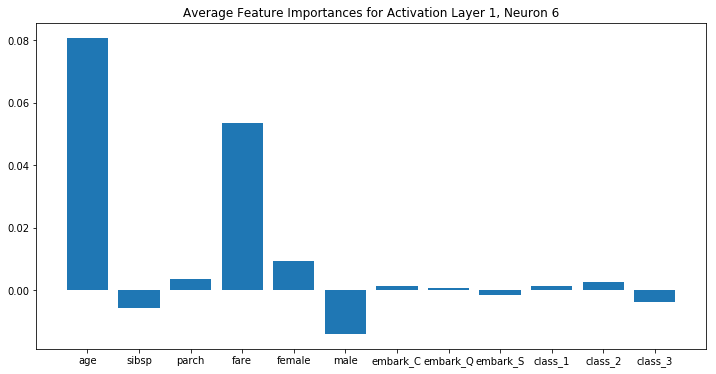

In [30]:
# In layer 1, neuron 6 has highest average conductance,
# cross reference with feature

nc_act1 = NeuronConductance(net, net.act1)

nc_vals6 = nc_act1.attribute(test_input_tensor, neuron_index=6, target=1)\
  .detach().numpy()

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x_pos, nc_vals6.mean(axis=0))
ax.set_xticks(x_pos)
ax.set_xticklabels(list(feature_names))
ax.set_title('Average Feature Importances for Activation Layer 1, Neuron 6')
plt.show()

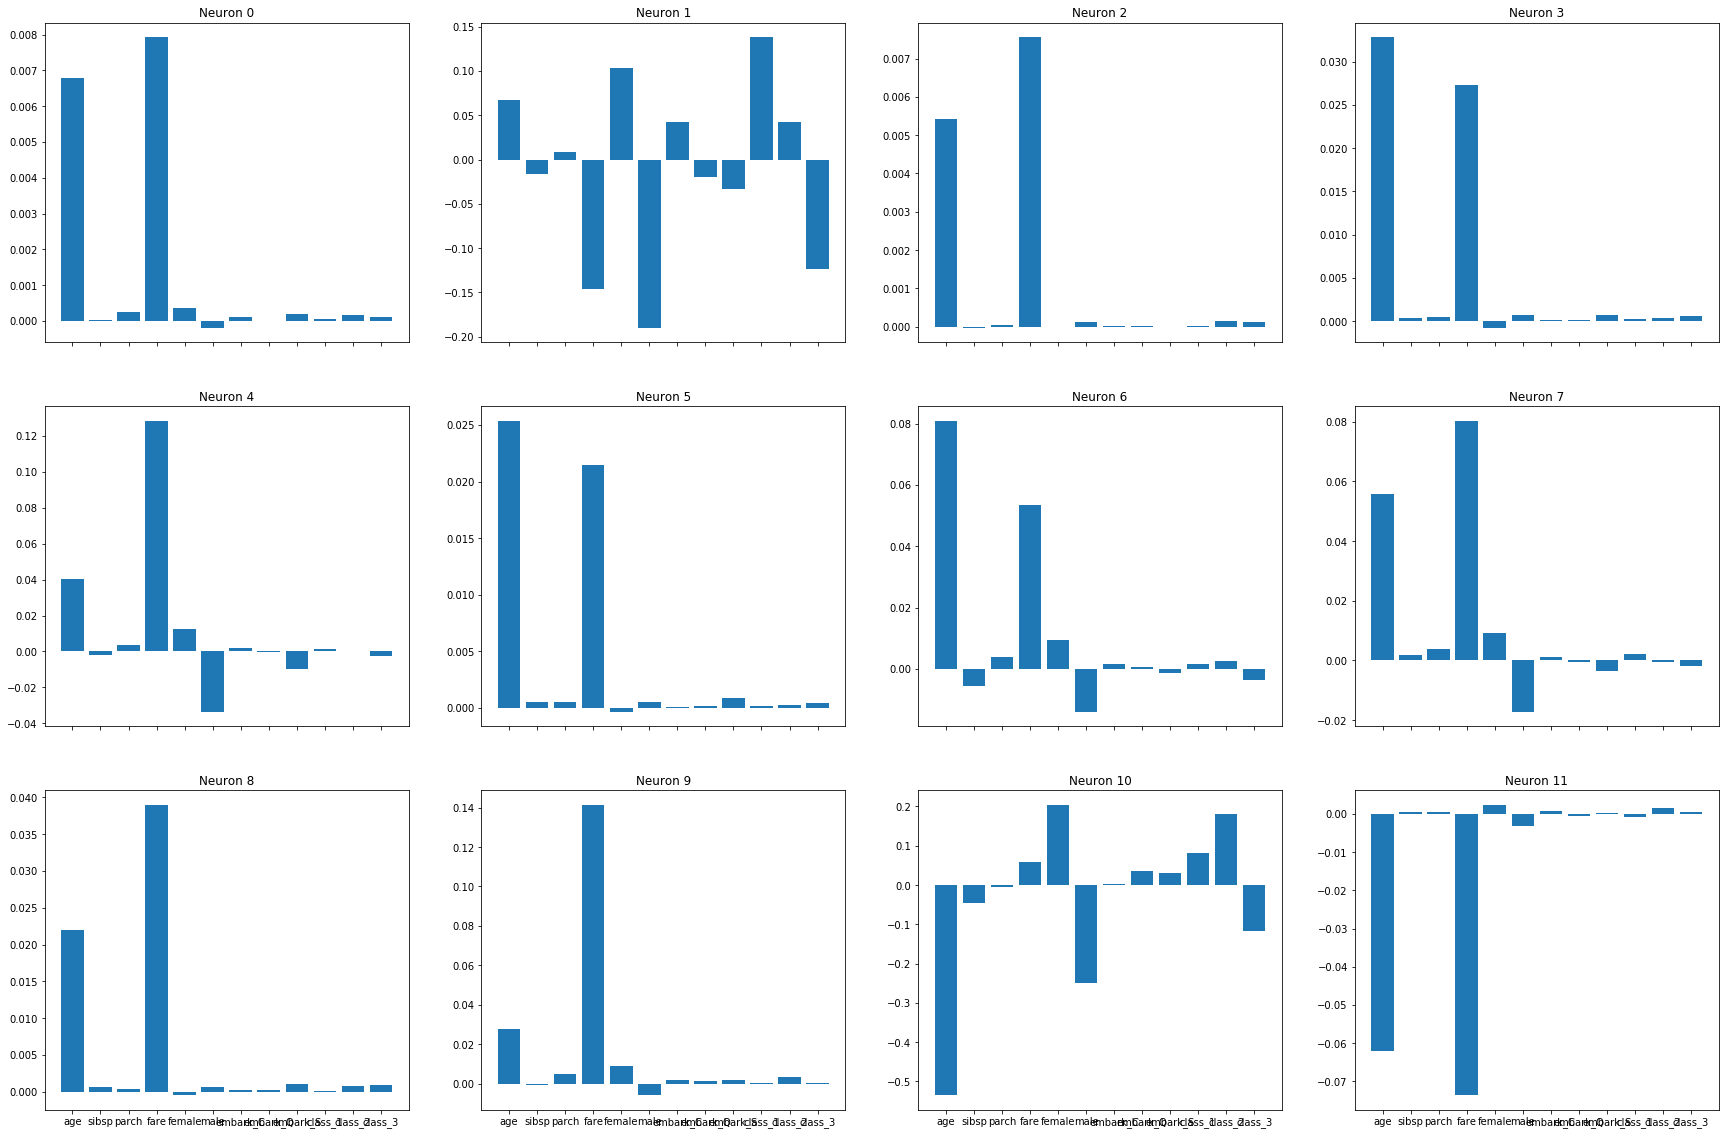

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20), sharex=True)
axes = axes.flatten()

for i in range(12):
  nc_vals = nc_act1.attribute(test_input_tensor, neuron_index=i, target=1)\
    .detach().numpy()

  ax = axes[i]
  ax.bar(x_pos, nc_vals.mean(axis=0))
  ax.set_xticks(x_pos)
  ax.set_xticklabels(list(feature_names))
  ax.set_title(f'Neuron {i}')

plt.show()